In [1]:
#Importing Libraries

import pandas as pd
import datetime
import time 
import numpy as np
import matplotlib
# matplotlib.use('nbagg') : matplotlib uses this protocall which makes plots more user intractive like zoom in and zoom out
matplotlib.use('nbagg')
import matplotlib.pylab as plt
import seaborn as sns#Plots
from matplotlib import rcParams#Size of plots  
import mpu

import warnings
warnings.filterwarnings("ignore")
sns.set()

# Outlier removal

After analyzing the features in the last notebook, it makes sense to make the dataset easier for an algoirithm to fit, by taking care of outliers. As the dataset was found to be relatively intuitive, outlier removal is going to be fairly conservative: All numerical outliers for `lat`, `lon` and `dist`, will be removed in a very small percentage as part of the univariate outlier removal process.

Furthermore, the main feature that will used for prediction, which is number of trips per hour, wil be clipped into the 0.001-0.999 range.

In [35]:
# Load and clean
raw_pd = pd.read_csv('../data/raw/routes.csv', delimiter='\t')
raw_pd = raw_pd.dropna()
raw_pd.request_date = pd.to_datetime(raw_pd.request_date)
data = raw_pd

In [7]:
data['distance'] = data.apply(lambda x: 
    mpu.haversine_distance(
        (x['source_latitude'], x['source_longitude']), 
        (x['destination_latitude'], x['destination_longitude'])
    ),
    axis=1
)

In [8]:
data.to_csv('../data/interim/raw_data_with_haversine_distance')

In [9]:
lower005 = data.quantile(q=0.005)

In [10]:
upper995 = data.quantile(q=0.995)

In [11]:
lower005, upper995

(passenger_id             14368.000000
 source_latitude            -12.208500
 source_longitude           -77.128459
 destination_latitude       -12.205853
 destination_longitude      -77.125712
 distance                     0.489516
 Name: 0.005, dtype: float64, passenger_id             306028.000000
 source_latitude             -11.952346
 source_longitude            -76.912011
 destination_latitude        -11.946944
 destination_longitude       -76.916976
 distance                     21.204209
 Name: 0.995, dtype: float64)

In [12]:
tmp = data.copy().reset_index()
for col in ['source_latitude', 'source_longitude', 'destination_latitude', 'destination_longitude', 'distance']:
    lower = np.percentile(data[col], 00.1)
    upper = np.percentile(data[col], 99.9)
    tmp = tmp.query('{lower}<{col}<{upper}'.format(lower=lower, col=col, upper=upper))

In [13]:
len(data), len(tmp)

(2036062, 2019719)

In [17]:
tmp.to_csv('../data/interim/dropped_outlier_data_with_haversine_distance')

In [55]:
tmp

,index,passenger_id,source_latitude,source_longitude,source_address,destination_latitude,destination_longitude,destination_address,request_date,distance
0,0,41037,-12.088156,-77.016065,"Avenida Nicolás de Arriola 314, La Victoria 13",-12.108531,-77.044891,"Calle Carlos Graña Elisande 340, San Isidro 27",2015-09-01 00:00:04,3.867246
1,1,116591,-12.099957,-77.036497,"Av Los Conquistadores 392, San Isidro 15073",-12.119686,-76.999969,"Bruselas 228, La Calera De La Merced",2015-09-01 00:00:15,4.536979
2,2,86426,-12.099153,-77.019425,"Av. República de Panamá 3537, San Isidro 27",-12.076505,-77.089305,"Av. La Marina cdra. 25, San Miguel 32",2015-09-01 00:00:17,8.004493
3,3,53610,-12.110271,-77.028945,"Junín 225, Miraflores",-12.132221,-77.027021,"Calle San Fernando 380, Miraflores 18",2015-09-01 00:00:29,2.449675
4,4,102927,-12.098430,-77.026246,"Av. República De Colombia 791, San Isidro",-12.099529,-76.990486,"Calle Mozart 201, San Borja 41",2015-09-01 00:00:31,3.889924
...,...,...,...,...,...,...,...,...,...,...
2036057,2045255,304744,-12.060781,-77.111638,"Jirón Lola Vilar 240, Bellavista 2",-12.083261,-77.067139,"Sucre, Pueblo Libre",2015-12-30 23:59:52,5.446167
2036058,2045256,290386,-12.070189,-77.106793,"Av. La Marina s/n, El Callao",-12.105407,-77.013802,"Calle 26 142, San Isidro 27",2015-12-30 23:59:53,10.842745
2036059,2045257,98815,-12.053719,-76.973228,"Calle Mineria 320, Santa Anita 43",-12.107983,-77.013924,"Calle 32 176, San Isidro 27",2015-12-30 23:59:55,7.482519
2036060,2045258,196924,-12.116891,-77.045441,"Calle Manuel Tovar 181, Miraflores 18",-12.129407,-77.032799,"Calle Diego Ferre 218, Miraflores 18",2015-12-30 23:59:55,1.955961


## Change gears to temporal data: trips-per-hour

In [56]:
data2 = tmp.set_index(tmp.request_date)
data2.drop(['passenger_id', 'source_address', 'destination_address', 'request_date'], 1, inplace=True)

In [57]:
data2['trip_counts'] = 1
trips  = data2.resample('1H')[['trip_counts']].sum()

In [58]:
lower = np.percentile(trips.trip_counts, 00.1)
upper = np.percentile(trips.trip_counts, 99.9)
trips2 = trips.where(trips.trip_counts > lower, lower).where(trips.trip_counts < upper, upper)

lower, upper

(20.424, 10531.160000000098)

In [23]:
trips2.to_csv('../data/interim/trips_per_hour_dropped_na_and_all_outliers_under_001_and_over_999.csv')

In [59]:
trips2

,trip_counts
request_date,
2015-09-01 00:00:00,705.000
2015-09-01 01:00:00,476.000
2015-09-01 02:00:00,489.000
2015-09-01 03:00:00,559.000
2015-09-01 04:00:00,353.000
...,...
2015-12-30 20:00:00,532.000
2015-12-30 21:00:00,587.000
2015-12-30 22:00:00,703.000


<IPython.core.display.Javascript object>


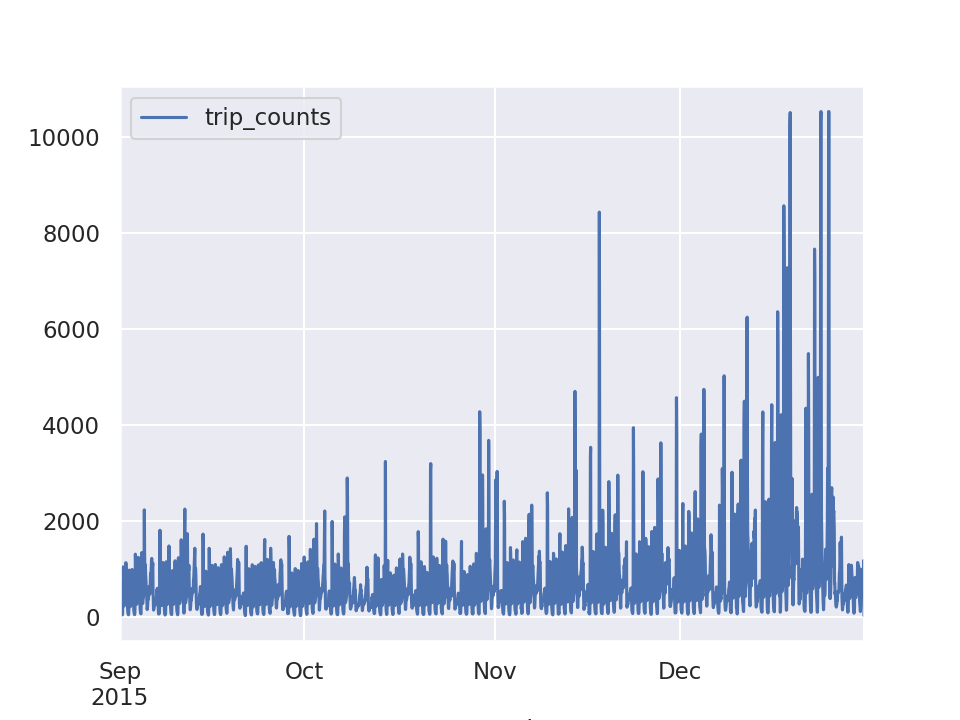

In [24]:
# Let's plot the new data:
trips2.plot()
plt.show()

# Timeseries Exploration

In the following section, the raw data are grouped in monthly, weekly, daily and hourly trip counts, so as to get a feel of the trend and seasonality of the series. 

Let's start by incrementally thinning the time buckets and watch as trend and seasonality is introduced in the plots.

In [42]:
raw_pd['trip_count'] = 1
raw_pd = raw_pd[['request_date', 'trip_count']]

In [43]:
# We start with a 122 days of data as shown:
len(raw_pd.groupby(
    by=[
        raw_pd.request_date.dt.dayofyear,
    ]
).count())

122

<IPython.core.display.Javascript object>


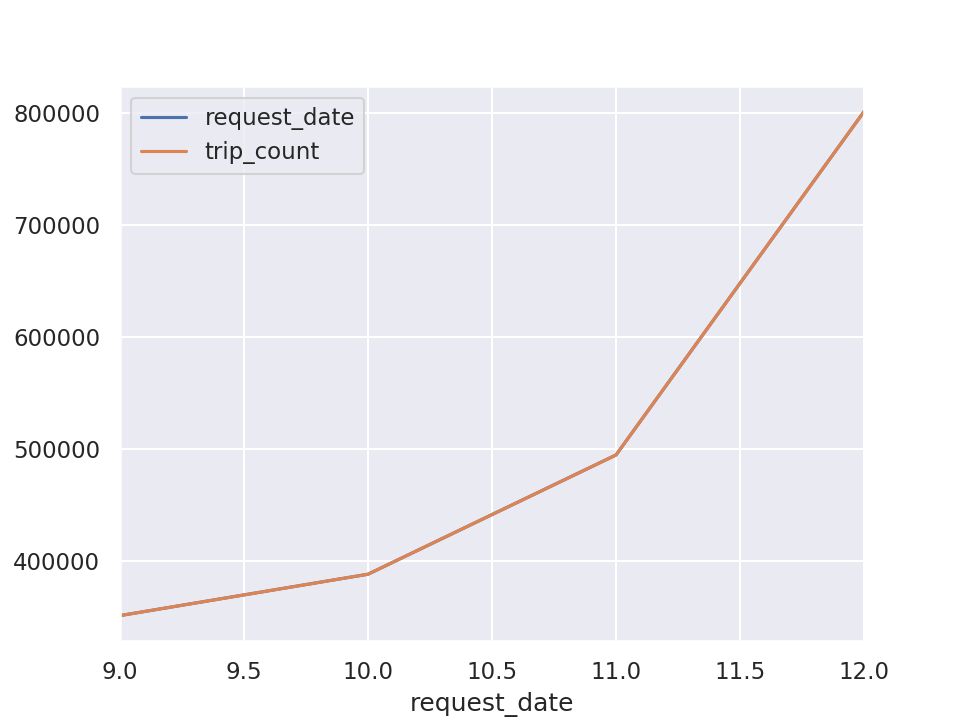

In [44]:
# Grouping by month allows a high level view of the trend:
raw_pd.groupby(
    by=[
        raw_pd.request_date.dt.month,
    ]
).count().plot()

plt.show()

<IPython.core.display.Javascript object>


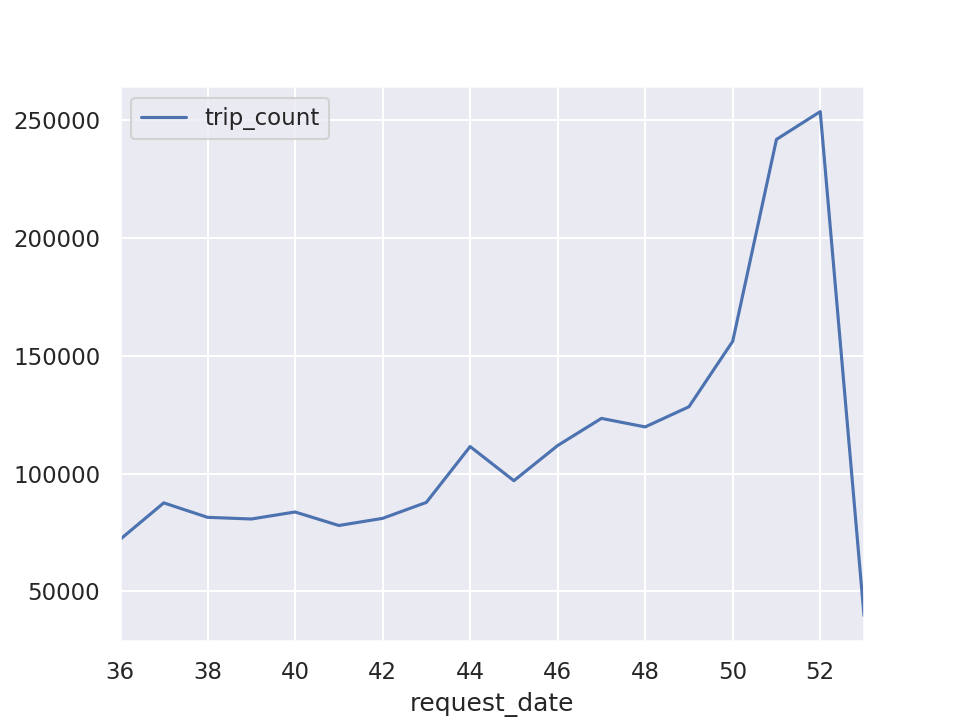

In [45]:
# Grouping per week shows a better view of the trend:
raw_pd.groupby(
    by=[
        raw_pd.request_date.dt.weekofyear,

    ]
).sum().plot()

plt.show()

<IPython.core.display.Javascript object>


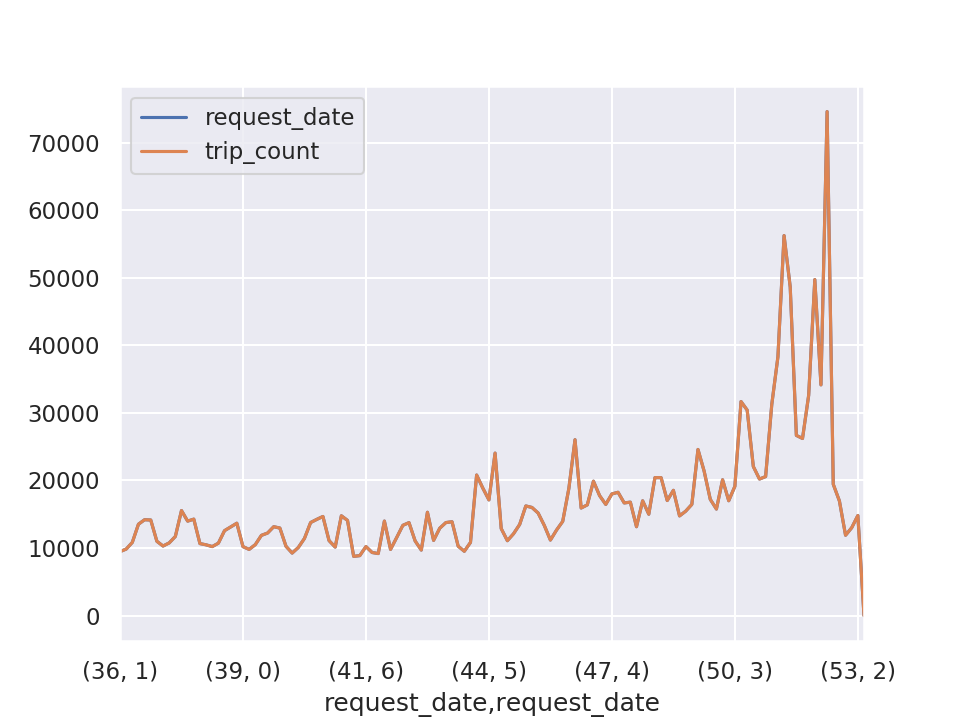

In [46]:
# Group per day of the year (this is equivalent), shows the weekly seasonality introduced on the trend
raw_pd.groupby(
    by=[
        raw_pd.request_date.dt.weekofyear,
        raw_pd.request_date.dt.dayofweek,
    ]
).count().plot()

plt.show()

<IPython.core.display.Javascript object>


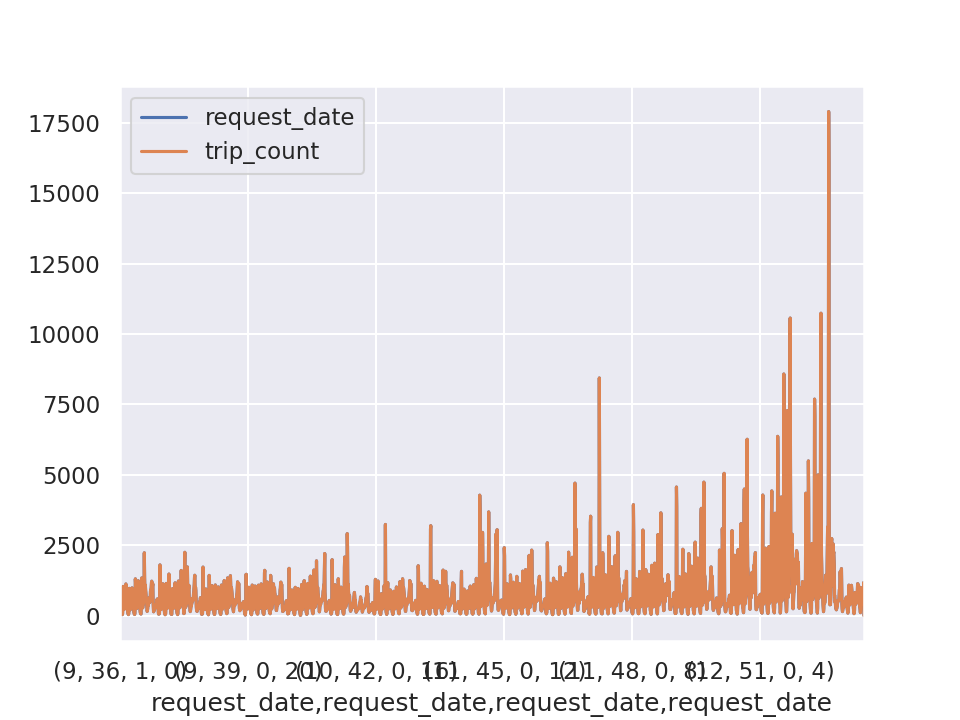

In [49]:
# Group per hour of year (equivalent here), also introduces the daily seasonality of the data
raw_pd.groupby(
    by=[
        raw_pd.request_date.dt.month,
        raw_pd.request_date.dt.weekofyear,
        raw_pd.request_date.dt.dayofweek,
        raw_pd.request_date.dt.hour
    ]
).count().plot()

plt.show()

<IPython.core.display.Javascript object>


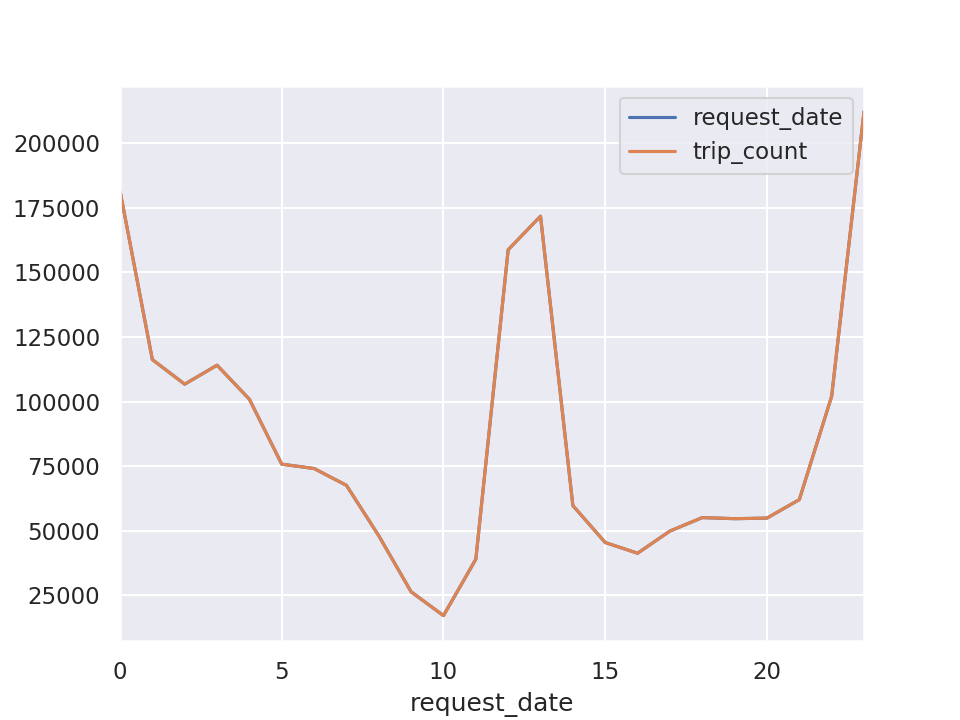

In [51]:
# Daily seasonality: A very strong indicator
raw_pd.groupby(
    by=[
        raw_pd.request_date.dt.hour,
    ]
).count().plot()

plt.show()

<IPython.core.display.Javascript object>


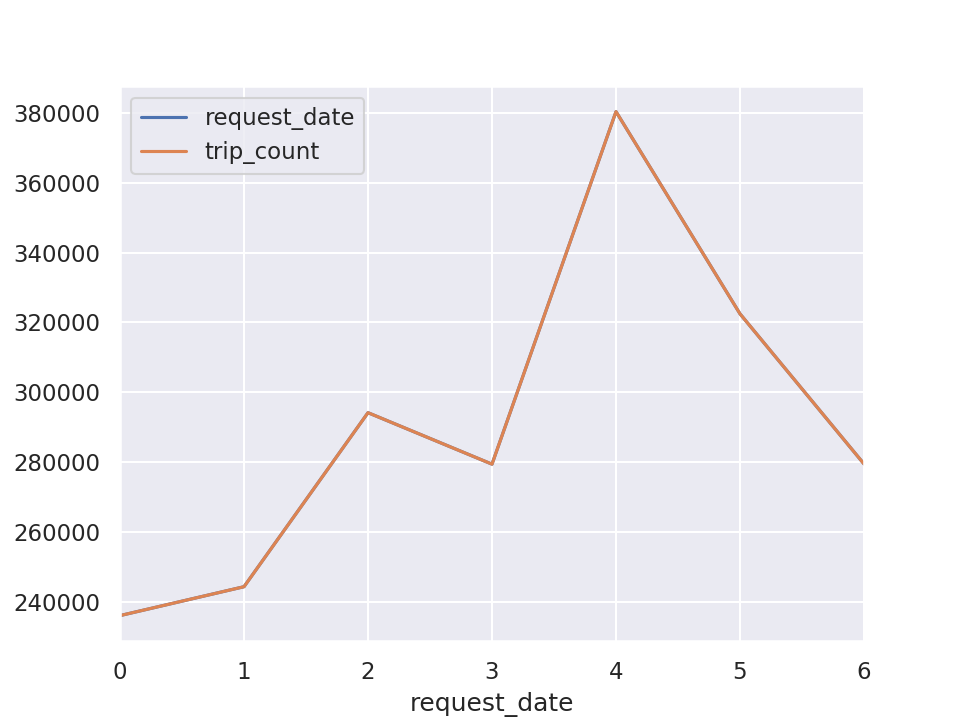

In [52]:
# Weekly seasonality: A strong indicator
raw_pd.groupby(
    by=[
        raw_pd.request_date.dt.dayofweek,
    ]
).count().plot()

plt.show()

# Conclusion

We have cleaned the raw data from outliers and enriched them with a new feature (distance). Next we transformed the data to hourly trip counts and explored their trend and seasonality. We easily determined an hour-of-day and day-of-week seasonality in trip counts. In the next section we will try our first method to predict this timeseries.